In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("results_full.csv")

metric = "LogLoss"
df = df[df["metric"] == metric]
#df = df[df['suite_id'] == 336]

splits = [s for s in df["split_method"].unique() if s.lower() != "random_split"]
 
method_order = [
    'ConstantPredictor','LogisticRegressor' , 'RandomForestClassifier', 'LGBMClassifier',
    'Engression', 'MLP', 'ResNet', 'FTTransformer', 'TabPFNClassifier', 'GPBoost_LogLoss'
]
rename_map = {
    'RandomForestClassifier': 'Random Forest',
    'RandomForestRegressor': 'Random Forest',
    'LGBMClassifier': 'Boosted Trees',
    'LGBMRegressor': 'Boosted Trees',
    'FTTransformer': 'FT-Transformer',
    'LogisticRegressor': 'Logistic Regression',
    'TabPFNClassifier': 'TabPFN',
    'GPBoost_LogLoss': 'GPBoost'
}

# 3) Extract unique suites, metrics, and extrapolation methods
suites  = df['suite_id'].unique()
metrics = df['metric'].unique()
methods = df['split_method'].unique()

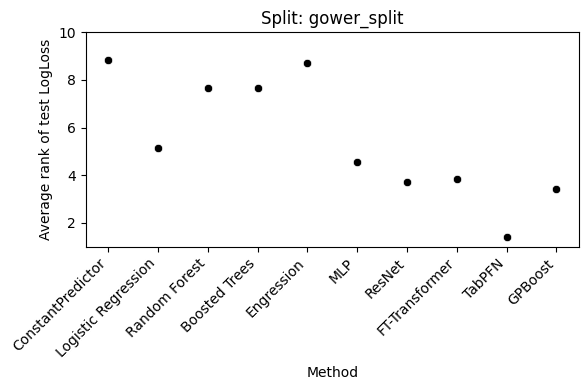

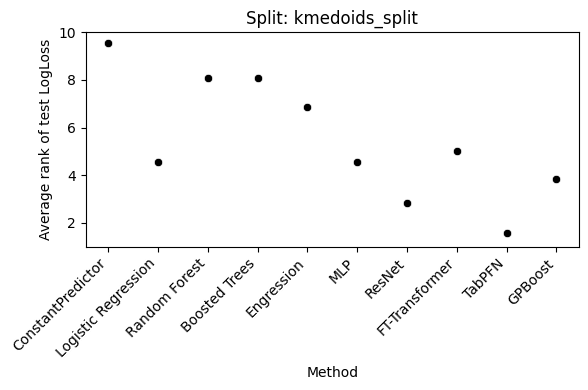

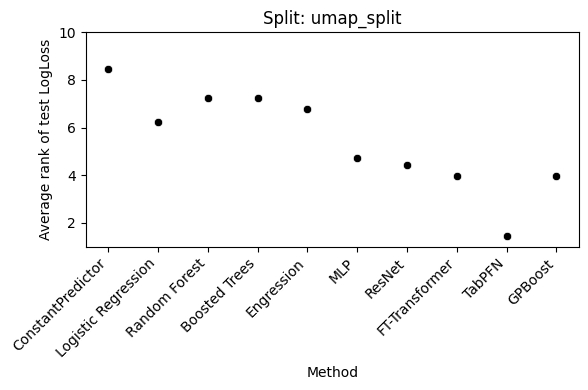

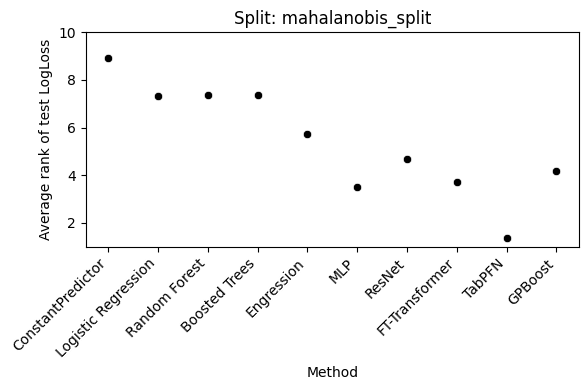

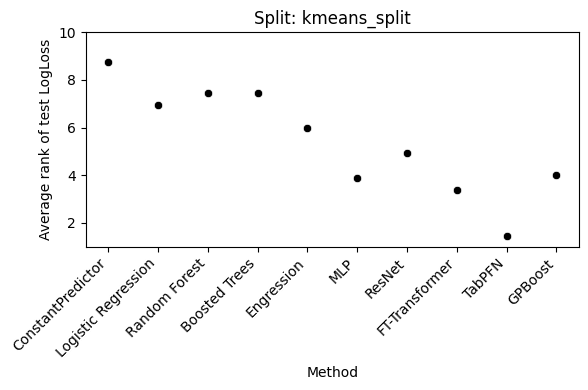

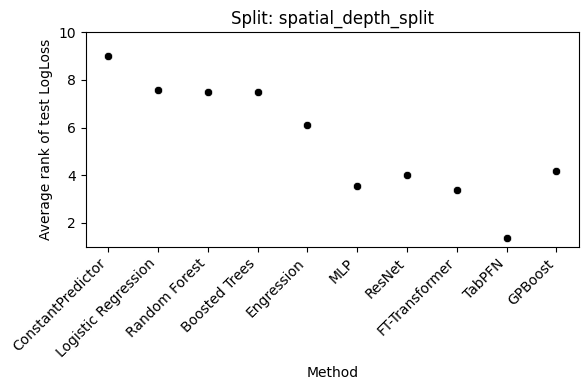

In [3]:
outdir = os.path.join('PICTURES', metric.lower())
os.makedirs(outdir, exist_ok=True)

for split in splits:
    sub = df[df["split_method"] == split]
    if sub.empty:
        continue

    table = sub.pivot(
        index="model",
        columns="task_id",
        values="value"
    )

    ranks = table.rank(ascending=True)  
    summary = pd.DataFrame({
        "Mean":   ranks.mean(axis=1),
        "Median": ranks.median(axis=1),
        "Std":    ranks.std(axis=1),
    }).reset_index().rename(columns={"model": "Method"})

    summary["Method"] = pd.Categorical(
        summary["Method"],
        categories=method_order,
        ordered=True
    )
    summary = summary.sort_values("Method")
    summary["Method"] = (
        summary["Method"]
        .astype(str)
        .map(rename_map)
        .fillna(summary["Method"].astype(str))
    )

    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=summary, x="Method", y="Mean", color='black')
    plt.xlabel("Method")
    plt.ylabel("Average rank of test LogLoss")
    plt.title(f"Split: {split}")
    plt.ylim(1, 10)        
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # 6) save
    fname = f"{split}_rankings_{metric}.png"
    plt.savefig(os.path.join(outdir, fname), bbox_inches='tight')
    plt.show()


In [4]:
df = df[df["metric"] == "LogLoss"]

df = df[df["split_method"] != "random_split"]

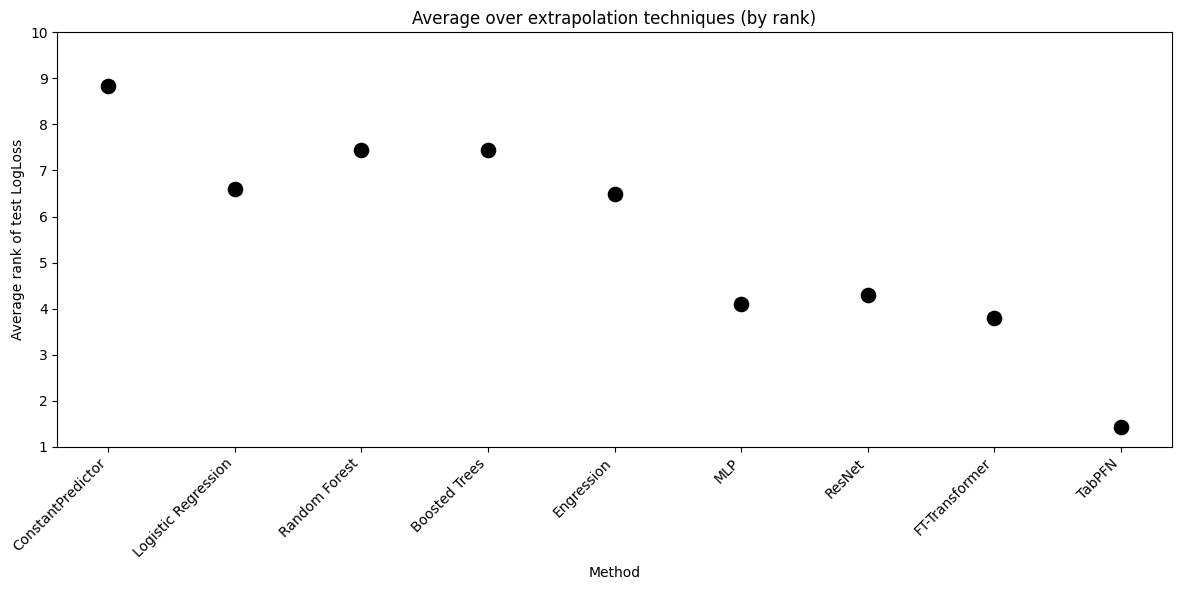

In [5]:
df["rank"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .rank(ascending=True)
)


overall = (
    df
    .groupby('model')['rank']
    .mean()
    .reset_index(name='Mean')
)


method_order = [
    'ConstantPredictor','LogisticRegressor',
    'RandomForestClassifier',
    'LGBMClassifier',  'Engression',
    'MLP', 'ResNet', 'FTTransformer', 'TabPFNClassifier', 'GPBosst_LogLoss'
]
overall = overall.set_index('model').reindex(method_order).reset_index()

rename_map = {
    'RandomForestClassifier':'Random Forest',
    'LGBMClassifier':       'Boosted Trees',
    'MLP':                  'MLP',
    'ResNet':               'ResNet',
    'FTTransformer':        'FT-Transformer',
    'LogisticRegressor':     'Logistic Regression',
    'TabPFNClassifier':     'TabPFN',
    'GPBosst_LogLoss':      'GPBoost'
 
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])


plt.figure(figsize=(12,6))
sns.scatterplot(data=overall, x='Method', y='Mean', color='black', s=150)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average rank of test LogLoss')
plt.xlabel('Method')
plt.title('Average over extrapolation techniques (by rank)')
plt.ylim(1, 10)
plt.tight_layout()

os.makedirs('PICTURES', exist_ok=True)
plt.savefig('PICTURES/average_rank_LogLoss.png', bbox_inches='tight')
plt.show()
